In [156]:
# ! pip install keras-rl2
# ! pip install chess
# ! pip install python-chess

In [157]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,\
     Input,BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

# import gym_chess

import chess
# import sys
# sys.path.insert(0, '../')
# sys.path.insert(0, '../alpha_beta')
# from MyChessBoard import MyChessBoard

In [158]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4301236862256654058
xla_global_id: -1
]


In [159]:
STATE_SHAPE = (65, )
NB_ACTIONS = 4096

In [160]:
def convert(x,square,map):
    for i in range(8):
        for j in range(8):
            if square[i][j]==map:
                x[i][j]=1
            elif square[i][j] == -map:
                x[i][j]=-1   
                 

In [161]:
class ChessEnv:
    '''
    state - obser: ndarray - (65,): [:65] is flatten from int_board; [65] is color of bot; 1 is white and -1 is black
    step: int. step_range = (0, 4096) , is encoded from square A to square B (64 x 64 val)
    reward: int
    '''

    mapped = {
            'P': 10,     # White Pawn
            'p': -10,    # Black Pawn
            'N': 20,     # White Knight
            'n': -20,    # Black Knight
            'B': 30,     # White Bishop
            'b': -30,    # Black Bishop
            'R': 40,     # White Rook
            'r': -40,    # Black Rook
            'Q': 50,     # White Queen
            'q': -50,    # Black Queen
            'K': 900,     # White King
            'k': -900     # Black King
    }
    point=[10,20,30,40,50,900]
     # state_shape = (8, 8)
    # nb_actions = 4096
    model = None
    
    def __init__(self, model: Sequential, neg_r_each_step = -1) -> None:
        self.env = chess.Board()
        self.model = model
        self.lastest_move=[]
        self.state = self.reset()
        # [-1] = 1 -> white, -1 -> black
        self.bot_color = self.env.turn * 2 - 1
        self.neg_r_each_step = neg_r_each_step

    def is_draw(self):
        if self.env.is_stalemate():
            print("statlemate")
            return True
        if self.env.is_fivefold_repetition():
            print("fivefold repetition")
            return True
        if self.env.is_seventyfive_moves():
            print("75 moves")
            return True
        if self.env.is_insufficient_material():
            print("Insufficient Material")
            return True
        return False

    def is_checkmate(self):
        # If There is checkmate then it will be TRUE else FALSE.It will be a boolean value.
        return self.env.is_checkmate()

    def convert_board_to_int(self):
        epd_string = self.env.epd()
        list_int = np.empty((0, ))
        for i in epd_string:
            if i == " ":
                list_int = list_int.reshape((8, 8))
                return list_int
            elif i != "/":
                if i in self.mapped:
                    list_int = np.append(list_int, self.mapped[i])
                else:
                    for counter in range(0, int(i)):
                        list_int = np.append(list_int, 0)
        list_int = list_int.reshape((8, 8))
        return list_int

    def get_state(self) -> np.ndarray:
        square=self.convert_board_to_int()
        x=np.zeros([8,8,8])
        for i in range(6):
            convert(x[i],square,self.point[i])
        moves=self.legal_moves()
        for move in moves:
            a=chess.parse_square(move.uci()[:2])
            b=chess.parse_square(move.uci()[2:])
            x[6][int(a /8)][a%8]=-1
            x[6][int(b /8)][b%8]=1
        if len(self.lastest_move) == 2:
            a=chess.parse_square(self.lastest_move[1].uci()[:2])
            b=chess.parse_square(self.lastest_move[1].uci()[2:])
            if self.lastest_move[0] ==1:
                x[7][7-int(a /8)][a%8]=-1
                x[7][7-int(b /8)][b%8]=1
            else:
                x[7][int(a /8)][a%8]=-1
                x[7][int(b /8)][b%8]=1
        return x   
        

    def legal_moves(self):
        return list(self.env.legal_moves)

    def encodeMove(self, move_uci:str):
        if len(move_uci) != 4:
            raise ValueError()
        a, b = chess.parse_square(move_uci[:2]), chess.parse_square(move_uci[2:])
        return a * 64 + b

    def decodeMove(self, move_int:int):
        a, b = move_int//64, move_int%64
        # a, b = chess.square_name(a), chess.square_name(b)

        move = self.env.find_move(from_square= a,to_square= b)
        return move

    def render(self):
        print(self.env.unicode())

    def reset(self):
        # random state
        redo = True
        num_sample_steps = 0
        while redo:
            redo = False
            self.env = chess.Board()
            num_sample_steps = np.random.randint(0, 15)
            for i in range (num_sample_steps):
                lg_move = self.legal_moves()
                if len(lg_move) != 0:
                    move = np.random.choice(self.legal_moves())
                    self.env.push(move)
                else:
                    redo = True
                    break
        self.lastest_move.append(1)
        if len(self.env.move_stack) !=0:
                self.lastest_move.append(self.env.move_stack[-1])
        if self.env.turn == False:
            self.env=self.env.mirror() 
            self.lastest_move[0]=0
        # Q_val = self.model.predict(self.get_state().reshape((1, 1) + STATE_SHAPE)).reshape(-1, )
        # print('Val:', min(Q_val), max(Q_val))
        return self.get_state()

    # def step(self, action: int):
    #     reward = 0
    #     done = True
        
    #     try:
    #         # move in legal move
    #         move = self.decodeMove(action)

    #         # neg reward each step
    #         reward = self.neg_r_each_step

    #         # location to_square
    #         to_r, to_c = move.to_square//8, move.to_square%8
    #         reward -= self.state[(7 - to_r)*8 + to_c ] * self.bot_color

    #         # action
    #         self.env.push(move)
    #         self.state = self.get_state()

    #         # check end game
    #         if self.is_checkmate():
    #             reward += self.mapped['K']
    #             done = True
    #             print('Win')
    #         elif self.is_draw():
    #             reward += 300
    #             done = True

    #         # opponent's turn   
    #         else:
    #             done = False
    #             Q_val = self.model.predict(self.state.reshape((1, 1) + STATE_SHAPE)).reshape(-1, )
    #             idx_sorted = np.argsort(Q_val)

    #             for act in idx_sorted:
    #                 try:
    #                     move = self.decodeMove(act)

    #                     # location to_square
    #                     to_r, to_c = move.to_square//8, move.to_square%8
    #                     reward -= self.state[(7 - to_r)*8 + to_c ] * self.bot_color

    #                     # action
    #                     self.env.push(move)
    #                     self.state = self.get_state()

    #                     # check end game
    #                     if self.is_checkmate():
    #                         reward -= self.mapped['K']
    #                         done = True
    #                         print("Lose")
    #                     elif self.is_draw():
    #                         reward += 300
    #                         done = True
                        
    #                     break
    #                 except:
    #                     continue

    #     except:
    #         # wrong move
    #         reward = -5000
    #         done = True
    #         print('wrong_move')

    #     return self.state, reward, done, {}


In [162]:
# model
model = Sequential()
model.add(Input((1, ) + STATE_SHAPE))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(NB_ACTIONS))
model.add(Activation('linear'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 65)                0         
                                                                 
 dense_48 (Dense)            (None, 128)               8448      
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_32 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_49 (Dense)            (None, 128)               16512     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                     

In [163]:
env = ChessEnv(model, neg_r_each_step=-1)

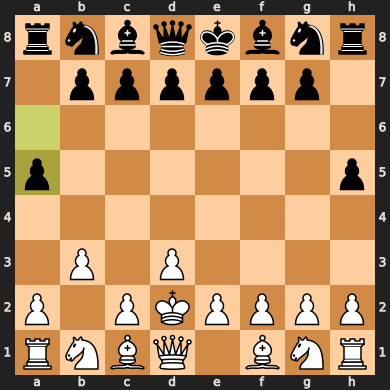

In [164]:
env.env

In [25]:
model.load_weights('chess_model_dqn.h5')

In [26]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=50000, window_length=1)
for i in range (10):
  policy = EpsGreedyQPolicy(0.01)
  dqn = DQNAgent(model=model, nb_actions=NB_ACTIONS, memory=memory,
                target_model_update=1e-2, policy=policy)
  dqn.compile(Adam(lr=1e-4), metrics=['mae'])

  # Okay, now it's time to learn something! We visualize the training here for show, but this
  # slows down training quite a lot. You can always safely abort the training prematurely using
  # Ctrl + C.
  his = dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)
  
  model.save('chess_model_dqn.h5')

Training for 50000 steps ...
[Move.from_uci('c2c4'), Move.from_uci('e7e5'), Move.from_uci('b2b3'), Move.from_uci('f8e7'), Move.from_uci('h2h4'), Move.from_uci('b7b6'), Move.from_uci('c1a3')]


ValueError: Error when checking input: expected input_2 to have 3 dimensions, but got array with shape (1, 1, 8, 8, 8)

In [ ]:
# # save dqn
# dqn.save_weights('dqn_{}_weights.h5f'.format('chess'), overwrite=True)

# # save model
# model.save('chess_model.h5')

# from google.colab import files

# files.download('chess_model.h5')

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('chess_model.h5')